This notebook is a supplement to the paper ["The Orthologic of Epistemic Modals"](https://escholarship.org/uc/item/0ss5z8g3) by [Wesley H. Holliday](mailto:wesholliday@berkeley.edu) and [Matthew Mandelkern](mandelkern@nyu.edu). The notebook focuses on the *possibility semantics* for modal orthologic discussed in Section 4 of the paper.

To view the notebook online, type the URL of this notebook (https://github.com/wesholliday/ortho-modals/blob/main/poss-semantics.ipynb) into the location field at https://nbviewer.org. GitHub's preview of the notebook might not show all the output that was generated.


# Notebook Outline

### 1. Compatibility frames

### 2. The ortholattice of regular sets

### 3. Hasse diagrams of lattices

### 4. Operations on regular sets

### 5. Compatibility frames with the same refinement relation but non-isomorphic ortholattices

### 6. Epistemic modals

### 7. Interpreting formulas

### 8. Transforming world models into epistemic compatibility models

### 9. Lifting a selection function from the world model to the epistemic compatibility model

### 10. Epistemic levels

In [1]:
import copy
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.pyplot as plt
from itertools import product

import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from tqdm.notebook import tqdm

In [2]:
from itertools import chain, combinations, product

def powerset(iterable):
    """powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"""
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

## 1. Compatibility frames

In [3]:
# when defining compatibility frames, 
# in order to avoid entering pairs (x,x) manually, we sometimes use the following:

def reflexive_closure(rel,X):
    """given a binary relation rel on X, returns the reflexive closure of rel"""
    relset = set(rel)

    for x in X:
        if not (x,x) in relset:
            rel.append((x,x))
    return rel

In [4]:
def domain(rel):
    """given a relation assumed to be reflexive, returns the domain of the relation"""
    X = {pair[0] for pair in rel}
    
    return X

In [5]:
def rel_to_reldict(rel):
    """Convert the given relation rel into a dictionary representing the relation"""
    
    reldict = dict()
    dom = domain(rel)
    for x in dom:
        reldict[x] = list()
        
    for pair in rel:
        reldict[pair[0]].append(pair[1])

    return reldict

In [6]:
def draw_digraph(reldict,E=None):
    """given a relation dictionary reldict, draw the corresponding digraph (with no loops)
    with the optional set E highlighted in orange"""
    
    if E is None:
        E = []
    
    g = nx.DiGraph()
    g.add_nodes_from(reldict.keys())
    
    for x in reldict.keys():
        for y in reldict[x]:
            if not x == y: 
                g.add_edge(x,y)

    color_map = []
    for node in g:
        if node in E:
            color_map.append('orange')
        else:
            color_map.append('#1f78b4')

    pos = nx.kamada_kawai_layout(g)
    
    nx.draw(g,pos=pos,node_color=color_map, with_labels=True)
    
    plt.show() 

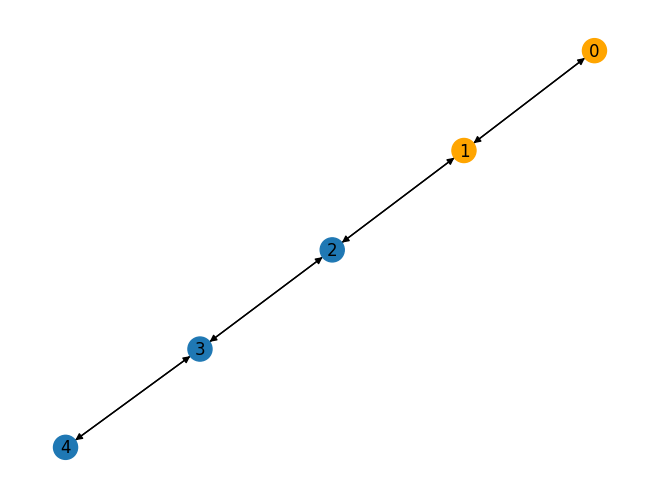

In [7]:
scale_rel = reflexive_closure([(0,1),(1,0),(1,2),(2,1),(2,3),(3,2),(3,4),(4,3)],range(5))
scale_rel_dict = rel_to_reldict(scale_rel)
draw_digraph(scale_rel_dict,[0,1])

## 2. The ortholattice of regular sets

Given a compatibility frame $(S,\between)$, consider the closure operator $c_\between: \wp(S)\to \wp(S)$ defined by $c_\between(A)=\{x\in S\mid \forall y\between x\,\exists z\between y: z\in A\}$.

What we call "$\between$-regular sets" in the paper are fixpoints of $c_\between$, i.e., sets $A\subseteq S$ such that $c_\between(A)=A$.

In [8]:
def closure(A,reldict,X = None):
    """given a subset A of X, returns the closure of A according to the closure operator
    defined from the compatibility relation dictionary reldict as above;
    if no X is given, we assume X = reldict.keys()"""

    if X is None:
        X = reldict.keys()
    
    Aset = set(A)
    Xset = set(X)
    closure = [x for x in A]
   
    for x in Xset - Aset:
        x_sees = set(reldict[x])
        sees_into_A = {y for y in X if any([z in Aset for z in reldict[y]])}
        if x_sees.issubset(sees_into_A):
            closure.append(x)
        
    return closure

For small compatibility frames, we can simply check for each subset whether it is a fixpoint of the closure operator.

In [9]:
def fixpoints_slow(reldict,X = None):
    """given a binary relation rel on X, returns the fixpoints of the closure operator defined above;
    if no X is given, we assume X = reldict.keys()"""

    if X is None:
        X = reldict.keys()
    
    fixpts = [(), tuple(X)]
    
    pwrset = powerset(X)

    for A in pwrset:
        if A == () or A == tuple(X):
            continue
            
        if A == tuple(closure(A,rel,X)):
            fixpts.append(A)

    return fixpts

To handle larger compatibility frames, we can use Ganter's algorithm to calculate fixpoints of a closure operator (Ganter B. (2010), "Two Basic Algorithms in Concept Analysis." In: Kwuida L., Sertkaya B. (eds) Formal Concept Analysis. ICFCA 2010. *Lecture Notes in Computer Science*, vol 5986. Springer, Berlin, Heidelberg. https://doi.org/10.1007/978-3-642-11928-6_22). 

Ganter's algorithm assumes a closure operator on the powerset of a set $X$ where $X$ is an initial segment of the natural numbers (or otherwise linearly ordered). Thus, we include a function to convert a given compatibility frame to an isomorphic copy whose domain is an initial segment of the natural numbers.

In [10]:
def convert_to_nums(reldict, X = None):
    """Given a compatibility frame, return an isomorphic copy
    whose domain is an initial segment of the natural numbers plus
    a dictionary to go back from natural numbers to the original elements"""
    
    if X is None:
        X = reldict.keys()
    
    forward_map = {}
    inverse_map = {}
    count = 0
    
    for x in X:
        forward_map[x] = count
        inverse_map[count] = x
        count += 1  
    
    newreldict = dict()
    
    for x in reldict.keys():
        newreldict[forward_map[x]] = list()
        for y in reldict[x]:
            newreldict[forward_map[x]].append(forward_map[y])
    
    return newreldict, inverse_map

We implement the algorithm on p. 316 of Ganter's paper with the following two functions.

In [11]:
def next_fixpoint(A, reldict, X = None):
    """Given a compatibility relation on an initial segment of the natural numbers
    and a subset A, assumed to be a fixpoint, calculate the next fixpoint
    according to Ganter's lectic ordering"""
    
    if X is None:
        X = reldict.keys()
        
    Aset = set(A)
    
    for i in reversed(X):
        if not i in Aset:
            iset = set(range(i))
            inter = Aset.intersection(iset)
            union = inter.union({i})
            Anext = closure(union, reldict, X)
            if [j for j in Anext if j<i and not j in Aset] == []:
                return tuple(Anext) 

In [12]:
def fixpoints(reldict, X = None):
    """Given a compatibility relation, return the fixpoints according to Ganter's algorithm;
    if rel is not already on an initial segment of the natural numbers, 
    apply convert_to_nums in order to run next_fixpoint and then apply 
    the inverse map to get corresponding fixpoints for the original rel"""
    
    if X is None:
        X = reldict.keys()
        
    if tuple(X) == tuple(range(len(X))):
        
        listX = list(X)
        setX = set(X)
    
        fixpts = [set()]
        A = ()
    
        while not set(A) == setX:
            A_next = next_fixpoint(A,reldict,listX)
            A = A_next
            fixpts.append(set(A_next))
        
        return fixpts
    
    else:
        conv = convert_to_nums(reldict, X)
        newreldict = conv[0]
        inverse = conv[1]
        newX = newreldict.keys()
        
        listX = list(newX)
        setX = set(newX)
        
        fixpts = [set()]
        A = ()
    
        while not set(A) == setX:
            A_next = next_fixpoint(A,newreldict,listX)
            A = A_next
            A_next_inverse = tuple({inverse[a] for a in A_next})
            fixpts.append(set(A_next_inverse))
        
        return fixpts

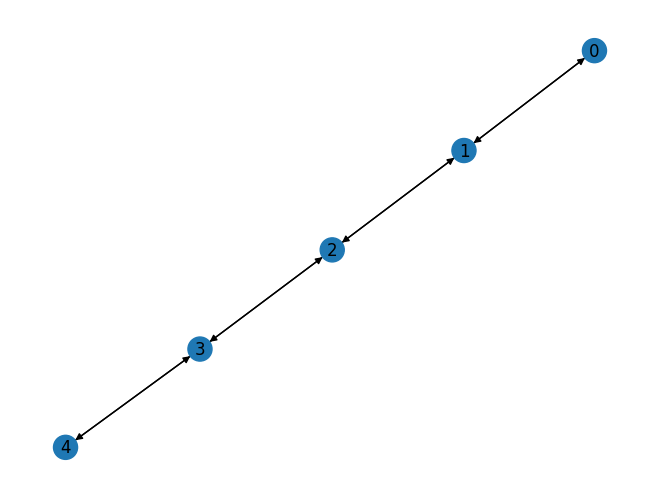

In [13]:
#Recall the compatibility frame for the Epistemic Scale
draw_digraph(scale_rel_dict)

In [14]:
scale_lat = fixpoints(scale_rel_dict)
print(len(scale_lat))
print(scale_lat)

10
[set(), {4}, {3, 4}, {2}, {2, 3, 4}, {0}, {0, 4}, {0, 1}, {0, 1, 2}, {0, 1, 2, 3, 4}]


## 3. Hasse diagrams of lattices

Given a family of regular sets, we first calculate the proper subset relation between them, then calculate the associated covering relation, and finally create a networkx digraph for the Hasse diagram of the lattice of regular sets.

In [15]:
def propsubrel(lt):
    """given a list of tuples representing a set of sets, returns the proper subset relation as a list of pairs"""
    propsubrel = []
    
    for A in lt:
        for B in lt:  
            if set(A).issubset(set(B)) and not set(B).issubset(set(A)):
                propsubrel.append((A,B))
                
    return propsubrel

In [16]:
def covering(spo):
    """given a strict partial order spo, returns the associated covering relation"""
    cover = copy.deepcopy(spo)
    for p1 in spo:
        for p2 in spo:
            if p1 in cover and p1[0] == p2[0] and (p2[1],p1[1]) in spo:
                cover.remove(p1)
                break
    return cover

In [17]:
def lattice(regsets):
    """given a family of regular sets, returns the Hasse diagram of the lattice of regular sets"""
        
    regtuples = [tuple(A) for A in regsets]
    cover = covering(propsubrel(regtuples))
    l = nx.DiGraph()
    l.add_nodes_from(regtuples)
    l.add_edges_from(cover) 
    
    return l

/var/folders/r5/_dfyhx994rg13y_svkv360b40000gn/T/ipykernel_14431/1908122675.py:7: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(lrev, prog="dot")


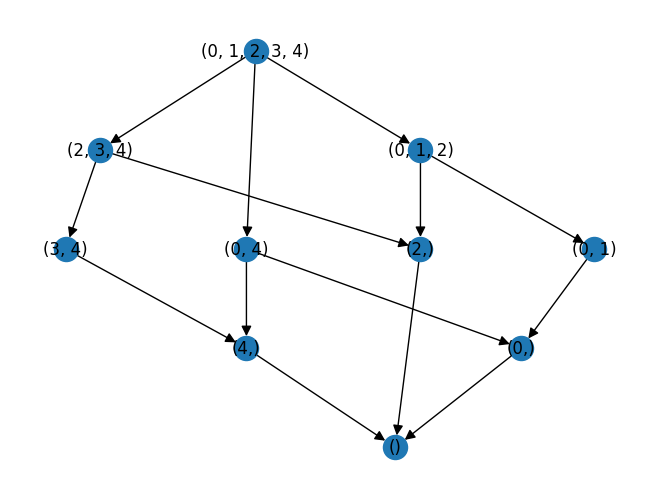

In [18]:
l = lattice(scale_lat)

lrev = nx.DiGraph.reverse(l) 
# We reverse the lattice arrows because graphviz draws all arrows going down, 
# so if we did not do this, the top element of the lattice would appear at the bottom

pos = graphviz_layout(lrev, prog="dot")
nx.draw(lrev, pos, with_labels=True, arrowsize=15)
plt.show() 

## 4. Operations on regular sets

In [19]:
def neg(A,reldict,X = None):
    """given a subset A of a compatibility frame given by reldict
    return the orthocomplement of A"""
    
    setA = set(A)
    
    if X is None:
        X = reldict.keys()
        
    setX = set(X)
        
    negA = [x for x in setX if set([y for y in X if (y,x) in rel and y in setA]) == set()]
    
    return set(negA)

In [20]:
def neg(A,reldict,X = None):
    """given a subset A of a compatibility frame given by reldict
    return the orthocomplement of A"""
    
    setA = set(A)
    
    if X is None:
        X = reldict.keys()
        
    setX = set(X)
        
    negA = list()
    
    for x in setX:
        if not any([y in setA for y in reldict[x]]):
            negA.append(x)
    
    return set(negA)

In [21]:
def wedge(A,B):
    """Given two subsets of a compatibility frame, return their conjunction (intersection)"""
    return A.intersection(B)

In [22]:
def vee(A,B,reldict,X = None):
    """Given two subsets of a compatibility frame, return their disjunction (closure of union)"""
    return set(closure(A.union(B),reldict))

For example, let's verify De Morgan's law in the ortholattice from the Epistemic Scale.

In [23]:
for A in scale_lat:
    for B in scale_lat:      
        if not vee(A,B,scale_rel_dict) == neg(wedge(neg(A,scale_rel_dict),neg(B,scale_rel_dict)), scale_rel_dict):
            print("Violation of De Morgan's law!")

## 5. Compatibility frames with the same refinement relation but non-isomorphic ortholattices

In [24]:
def refinement(reldict,X=None):
    """Returns the set of pairs (x,y) such that y refines x (written $y\sqsubseteq x$ in the paper)
    according to compatibility relation rel"""

    if X is None:
        X = reldict.keys()
    
    refine = dict()
    for x in X:
        refine[x] = list()
        for y in X:
            if set(reldict[y]).issubset(set(reldict[x])):
                refine[x].append(y)
    return refine

In [25]:
# Consider the following two compatibility frames

rel_1 = rel_to_reldict(reflexive_closure([(0,1),(1,0),(1,2),(2,1),(2,3),(3,2),(3,4),(4,3), (5,1), (1,5), (3,6), (6,3)],range(7)))
rel_2 = rel_to_reldict(reflexive_closure([(0,1),(1,0),(3,4),(4,3), (5,1), (1,5), (3,6), (6,3)],range(7))) # Deleted the edges (1,2), (2,1), (2,3), (3,2) from rel_1

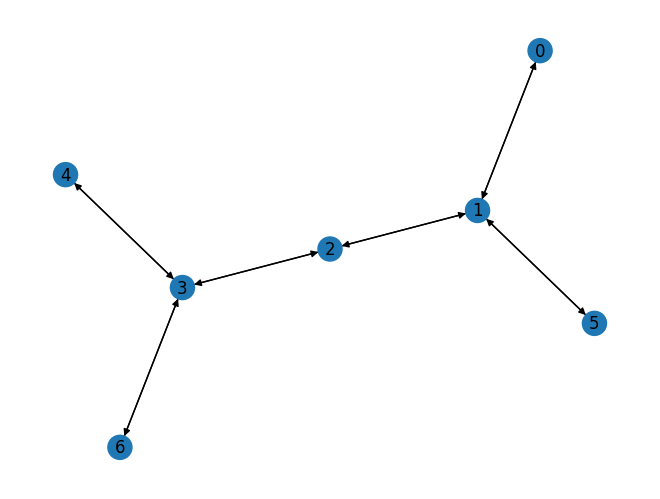

In [26]:
draw_digraph(rel_1)

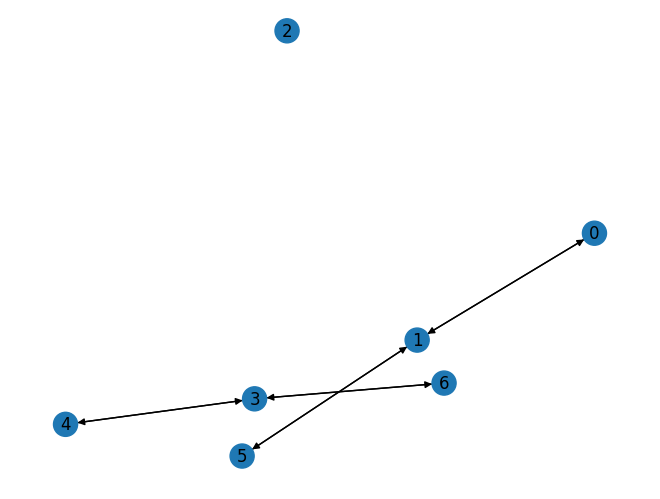

In [27]:
draw_digraph(rel_2)

In [28]:
# The ortholattices of the two frames are not isomorphic

l1_fixpts = fixpoints(rel_1)
l2_fixpts = fixpoints(rel_2)

l1 = lattice(l1_fixpts)
l2 = lattice(l2_fixpts)

nx.is_isomorphic(l1,l2)

False

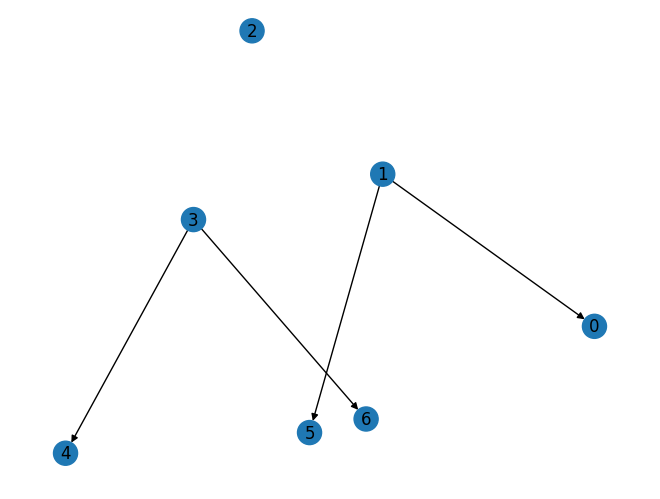

In [29]:
# The refinement relations of the two frames are the same

rel_1_ref = refinement(rel_1)
draw_digraph(rel_1_ref)

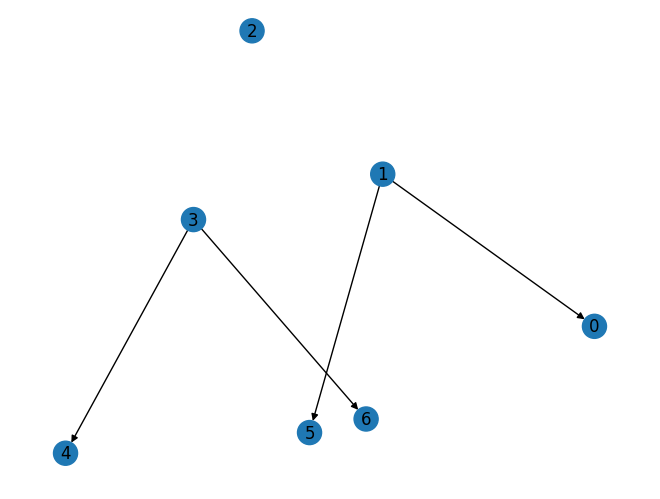

In [30]:
rel_2_ref = refinement(rel_2)
draw_digraph(rel_2_ref)

## 6. Epistemic modals

For modalities, in this notebook we use the accessibility relation representation instead of the accessibility function representation in order to use fewer possibilities in our frames.

In [31]:
def box(A, accessdict, X = None):
    """given a subset A of a compatibility frame with accessibility relation access
    return Box A"""
    
    setA = set(A)
    
    if X is None:
        X = accessdict.keys()
        
    BoxA = [x for x in setA if set(accessdict[x]).issubset(setA)]
    
    return set(BoxA)

In [32]:
def diamond(A, rel, access, X = None):
    """given a subset A of a compatibility frame with accessibility relation access
    return Diamond A"""
    
    return neg(box(neg(A,rel),access),rel)

In [33]:
access_on_scale_dict = rel_to_reldict(reflexive_closure([(1,0),(1,2),(3,2),(3,4)],range(5)))

# 7. Interpreting formulas

We take formulas to be strings and use the following symbols:

'~' for negation;

'L' for must;

'M' for might;

'^' for conjunction;

'v' for disjunction;

'>' for the conditional (used in Section 9).

In [34]:
def main_connective(formula):
    """
    Returns the main connective of the formula (or "prop" if s is a propositional variable) and 
    arguments to main connective (or propositional variable)
    """

    formula = formula.replace(" ", "")
        
    if len(formula) == 1:
        return "prop", formula

    if formula.startswith("~"):
        formula = formula.removeprefix("~")
        return "~", formula
    
    if formula.startswith("L"):
        formula = formula.removeprefix("L")
        return "L", formula

    if formula.startswith("M"):
        formula = formula.removeprefix("M")
        return "M", formula

    if formula.startswith("("):
            
        leftparen = 0
        rightparen = 0
        slength = len(formula)

        for n in range(slength):

            if formula[n] == "(":
                leftparen +=1

            if formula[n] == ")":
                rightparen +=1

            if leftparen - rightparen == 1:
                
                if formula[n] == "^":
                    return "^", formula[1:n], formula[n+1:-1]

                if formula[n] == "v":
                    return "v", formula[1:n], formula[n+1:-1] 
                
                if formula[n] == ">":
                    return ">", formula[1:n], formula[n+1:-1] 
                
    return None

In [35]:
def extension(formula, compat_rel, access_rel, valuation):
    """
    Given a formula, compatibility and accessibility relations, and a valuation,
    returns the extension of the formula as a set of possibilities
    """
    dom = access_rel.keys()
    
    main_connec = main_connective(formula)

    if main_connec[0] == 'prop':

        return set([x for x in dom if x in valuation[main_connec[1]]])

    if main_connec[0] == '~':
        inner_ext = set(extension(main_connec[1],compat_rel,access_rel,valuation))
        return neg(inner_ext, compat_rel)

    if main_connec[0] == 'L':
        inner_ext = set(extension(main_connec[1],compat_rel,access_rel,valuation))
        return box(inner_ext,access_rel)
    
    if main_connec[0] == 'M':
        inner_ext = set(extension(main_connec[1],compat_rel,access_rel,valuation))
        return diamond(inner_ext,compat_rel,access_rel)

    if main_connec[0] == '^':
        left_ext = extension(main_connec[1],compat_rel,access_rel,valuation)
        right_ext = extension(main_connec[2],compat_rel,access_rel,valuation)
        return wedge(left_ext,right_ext)

    if main_connec[0] == 'v':
        left_ext = extension(main_connec[1],compat_rel,access_rel,valuation)
        right_ext = extension(main_connec[2],compat_rel,access_rel,valuation)
        return vee(left_ext,right_ext,compat_rel)

In [36]:
scale_val = {'p': set({0,1})}

print("Extension of Lp:", extension('Lp',scale_rel_dict,access_on_scale_dict,scale_val))
print("Extension of p:", extension('p',scale_rel_dict,access_on_scale_dict,scale_val))
print("Extension of Mp:", extension('Mp',scale_rel_dict,access_on_scale_dict,scale_val))
print("Extension of (Mp ^ M~p):", extension('(Mp ^ M~p)',scale_rel_dict,access_on_scale_dict,scale_val))
print("Extension of M~p:", extension('M~p',scale_rel_dict,access_on_scale_dict,scale_val))
print("Extension of ~p:", extension('~p',scale_rel_dict,access_on_scale_dict,scale_val))
print("Extension of L~p:", extension('L~p',scale_rel_dict,access_on_scale_dict,scale_val))

Extension of Lp: {0}
Extension of p: {0, 1}
Extension of Mp: {0, 1, 2}
Extension of (Mp ^ M~p): {2}
Extension of M~p: {2, 3, 4}
Extension of ~p: {3, 4}
Extension of L~p: {4}


Extension of Lp:


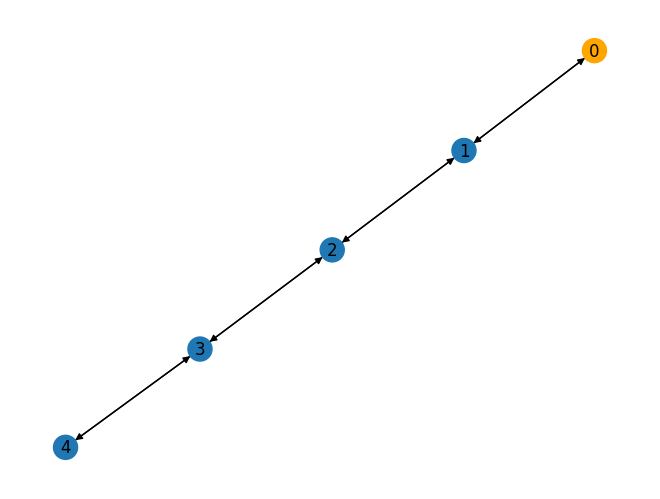

Extension of p:


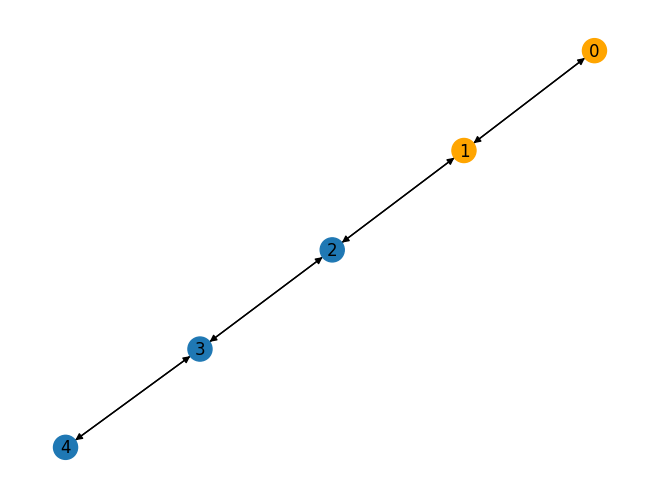

Extension of Mp:


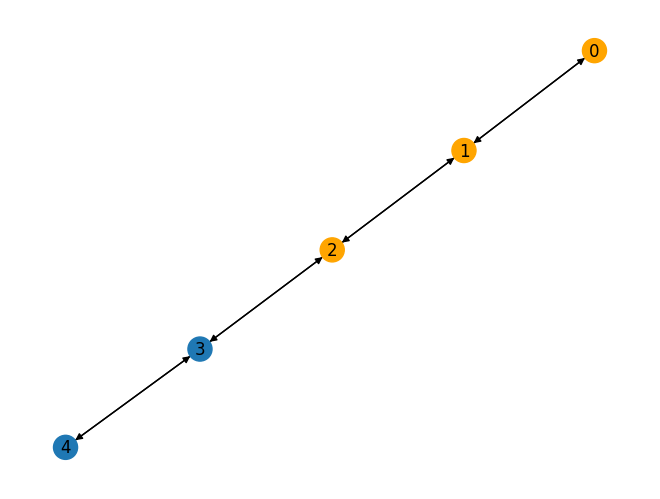

Extension of (Mp ^ M~p):


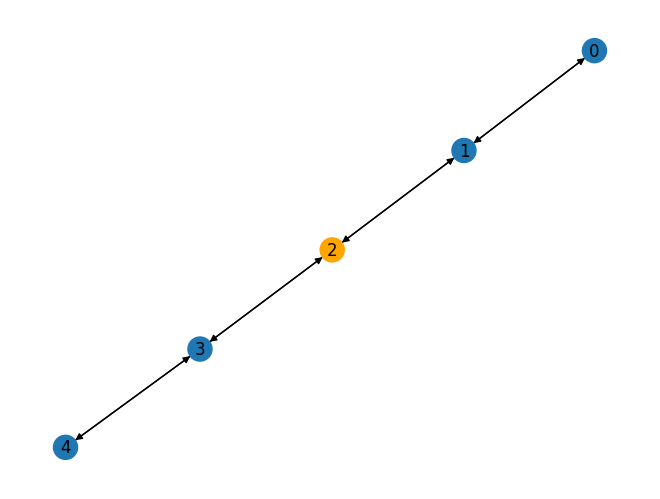

Extension of M~p:


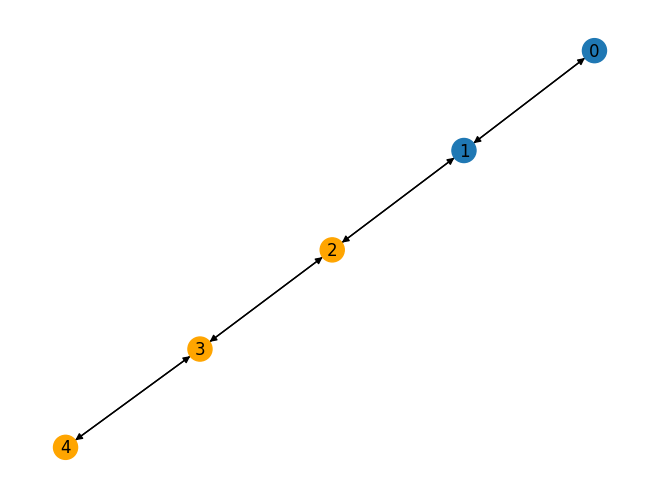

Extension of ~p:


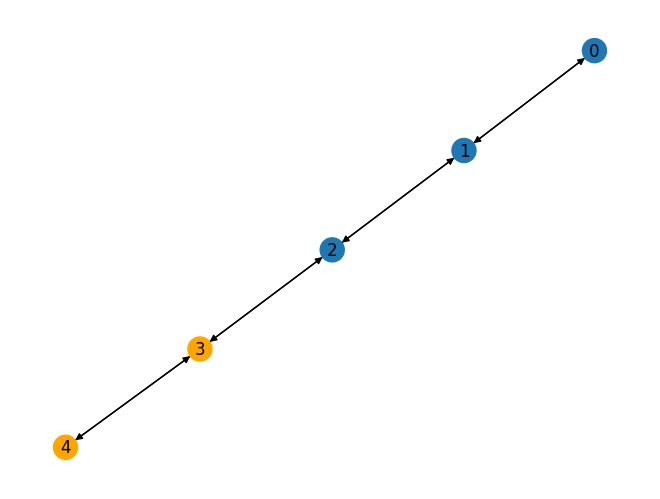

Extension of L~p:


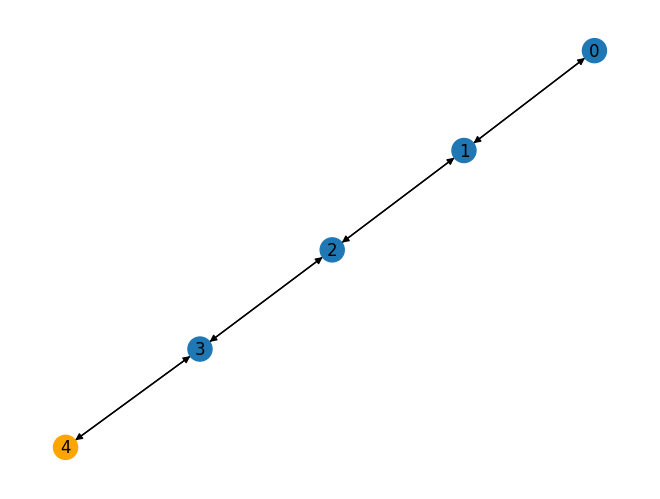

In [37]:
for form in ['Lp','p', 'Mp','(Mp ^ M~p)','M~p','~p','L~p']:
    print(f"Extension of {form}:")
    draw_digraph(scale_rel_dict, extension(form,scale_rel_dict,access_on_scale_dict,scale_val))

# 8. Transforming world models into epistemic compatibility models

In [38]:
from itertools import chain, combinations, product

def powerset(iterable):
    """powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"""
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [39]:
def compatibility_frame_from_worlds(worlds, valuation=None):
    """Given a set of worlds with a propositional valuation,
    construct the corresponding epistemic compatibility frame 
    with new_valuation and distinguished Boolean algebra B0"""

    possibilities = list()
    B0 = list()

    for true_prop in powerset(worlds):
        if len(true_prop) > 0:
            for known_prop in powerset(worlds):
                if set(true_prop).issubset(set(known_prop)):
                    possibilities.append((true_prop,known_prop))

        B0.append([poss for poss in possibilities if set(poss[0]).issubset(true_prop)])

    compatibility = dict()

    for poss1 in possibilities:
        compatibility[poss1] = list()
        for poss2 in possibilities:
            if len(set(poss1[0]).intersection(set(poss2[0])))>0 and set(poss1[0]).issubset(set(poss2[1])) and set(poss2[0]).issubset(set(poss1[1])):
                compatibility[poss1].append(poss2)

    accessibility = dict()

    for poss1 in possibilities:
        accessibility[poss1] = list()
        for poss2 in possibilities:
            if set(poss1[0]).issubset(set(poss2[0])) and set(poss2[1]).issubset(set(poss1[1])):
                accessibility[poss1].append(poss2)

    new_valuation = None

    if not valuation == None:

        new_valuation = dict()

        for prop_letter in valuation.keys():
            new_valuation[prop_letter] = [poss for poss in possibilities if set(poss[0]).issubset(set(valuation[prop_letter]))]
    
    return possibilities, compatibility, accessibility, new_valuation, B0


def probability_in_compatibility_frame_from_worlds(prop,world_prob):
    """Given a probability distribution on worlds and a proposition in
    the corresponding compatibility frame, return the probability of the proposition"""
    
    worlds = world_prob.keys()
    support = [w for w in worlds if world_prob[w] > 0]
    return sum([world_prob[w] for w in worlds if any([w in poss[0] for poss in prop if set(poss[1])==set(support)])])

In [40]:
def draw_frame(possibilities,compatibility,accessibility, E=None,title=None):

    if E is None:
        E = []

    compatibility_no_loops = list()
    accessibility_no_loops = list()

    for x in compatibility.keys():
        for y in compatibility[x]:
            if not x==y:
                compatibility_no_loops.append((x,y))
    
    for x in  accessibility.keys():
        for y in  accessibility[x]:
            if not x==y:
                 accessibility_no_loops.append((x,y))

    frame = nx.DiGraph()
    frame.add_nodes_from(possibilities)
    frame.add_edges_from(compatibility_no_loops) 

    color_map = []
    for node in frame:
        if node in E:
            color_map.append('orange')
        else:
            color_map.append('#1f78b4')

    if title == None:
        title = ""

    plt.title(title,fontsize = 10)
    
    pos = nx.kamada_kawai_layout(frame)
    nx.draw(frame,pos=pos,node_color=color_map,with_labels=True,edge_color="grey")
    nx.draw_networkx_edges(frame, pos,edgelist=accessibility_no_loops,edge_color='r', style="dashed",connectionstyle="arc3,rad=0.4")
    
    plt.show() 

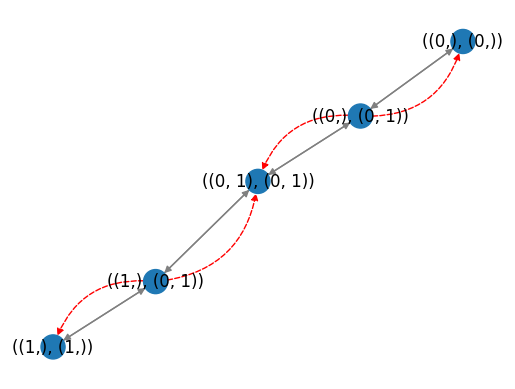

In [41]:
coin_flip = compatibility_frame_from_worlds(range(2))

draw_frame(coin_flip[0],coin_flip[1],coin_flip[2])

In [42]:
three_worlds_val = {'0':[0], '1':[1],'2':[2]}
three_worlds_prob = {0:1/3,1:1/3,2:1/3}
frame_from_three_worlds = compatibility_frame_from_worlds(range(3),three_worlds_val)

In [43]:
lattice_of_frame_from_three_worlds = lattice(frame_from_three_worlds[1])
len(lattice_of_frame_from_three_worlds)

19

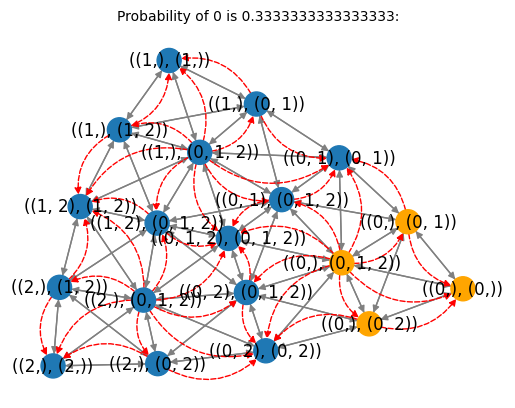

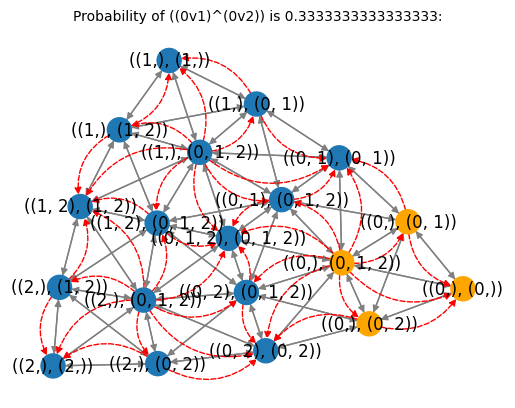

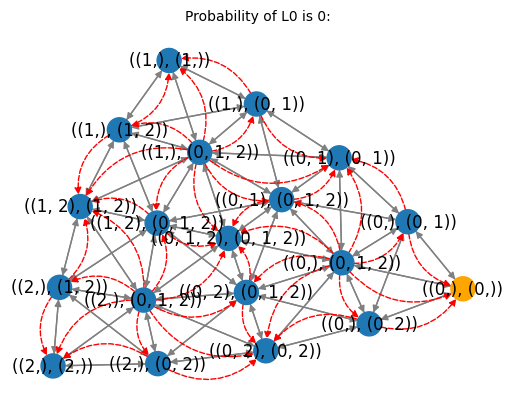

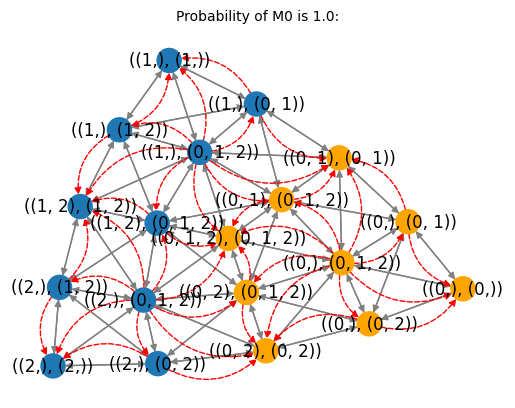

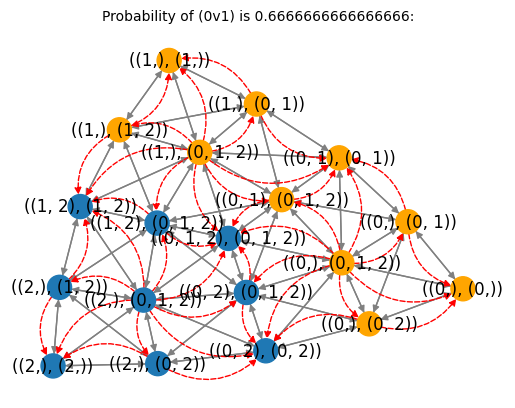

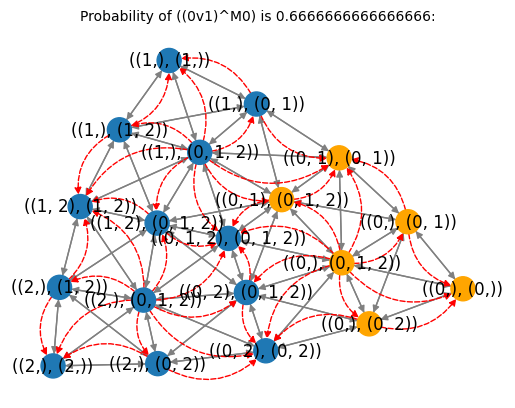

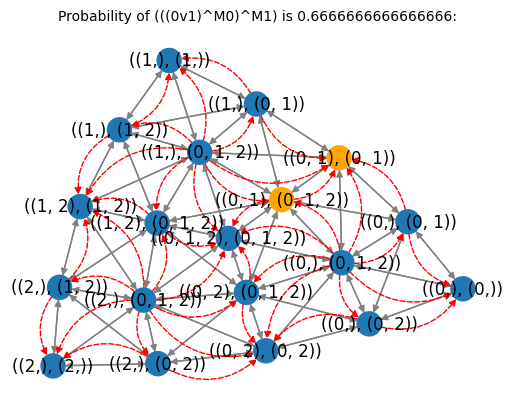

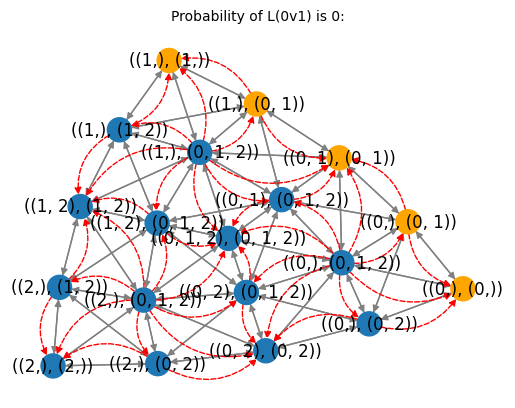

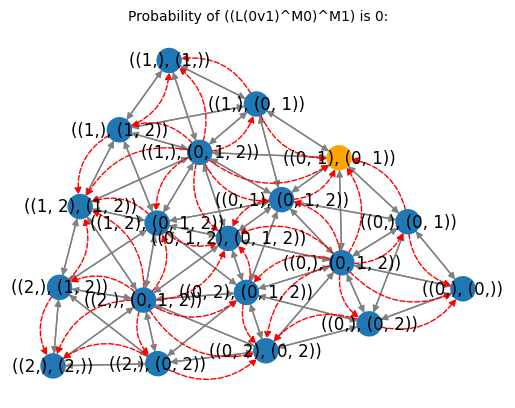

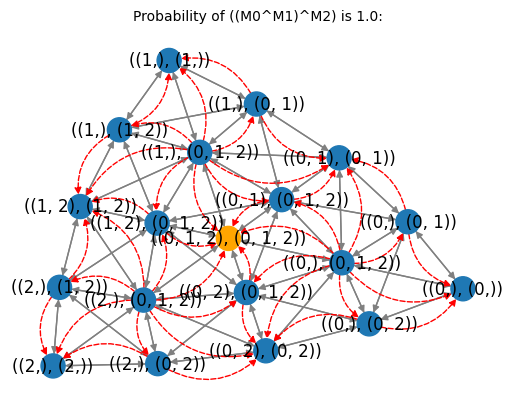

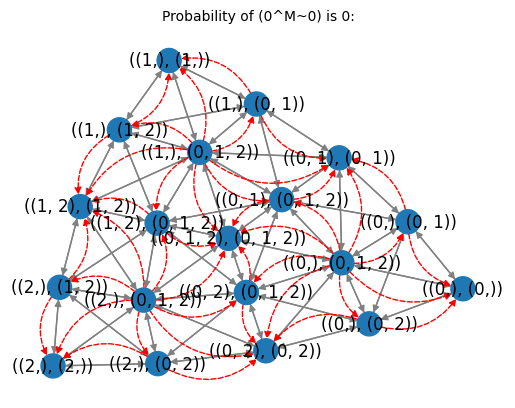

In [44]:
for form in ['0','((0v1)^(0v2))','L0','M0','(0v1)','((0v1)^M0)','(((0v1)^M0)^M1)','L(0v1)','((L(0v1)^M0)^M1)','((M0^M1)^M2)','(0^M~0)']:
    ext = extension(form,frame_from_three_worlds[1],frame_from_three_worlds[2],frame_from_three_worlds[3])
    prob = probability_in_compatibility_frame_from_worlds(ext,three_worlds_prob)
    draw_frame(frame_from_three_worlds[0],frame_from_three_worlds[1],frame_from_three_worlds[2],ext,title=f"Probability of {form} is {prob}:")

Suppose you learn that 2 did not obtain. Then we get the following:

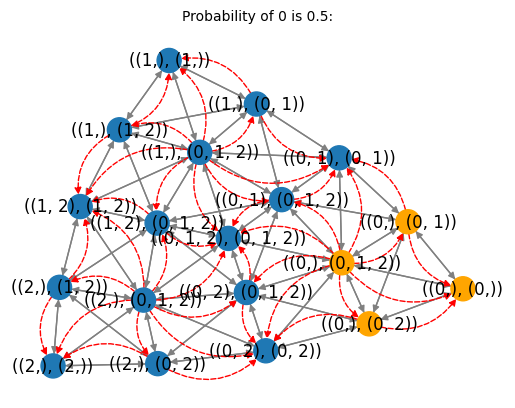

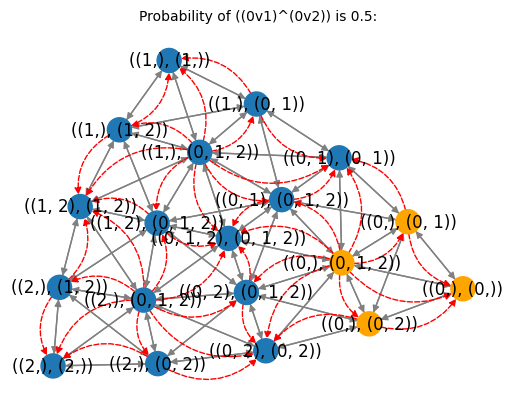

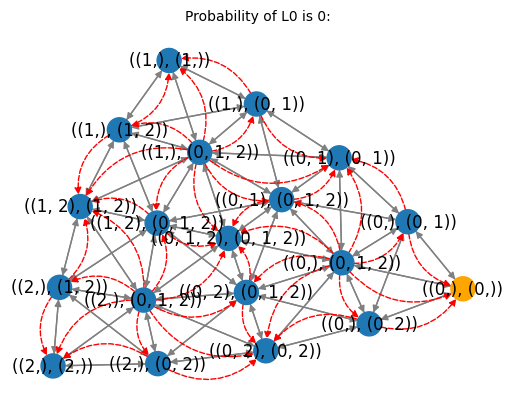

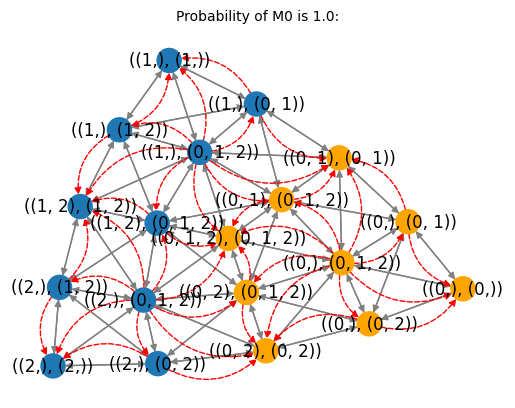

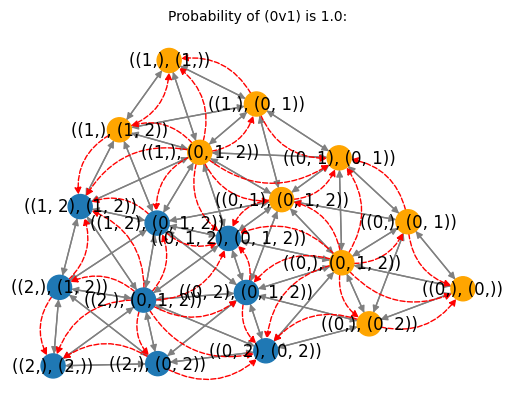

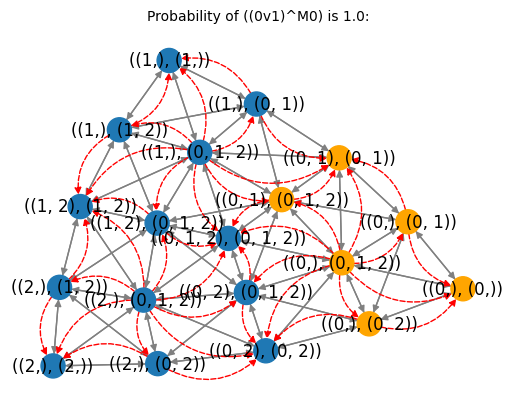

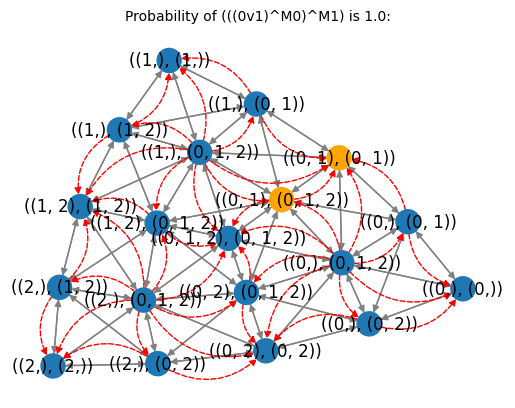

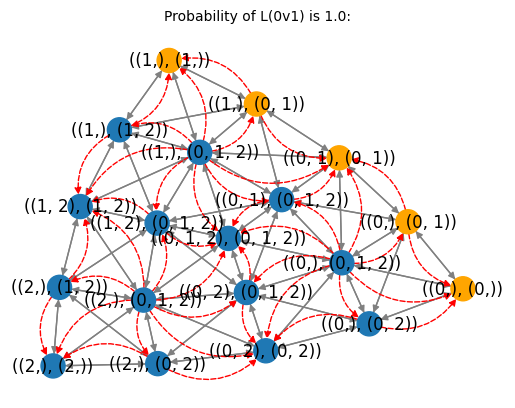

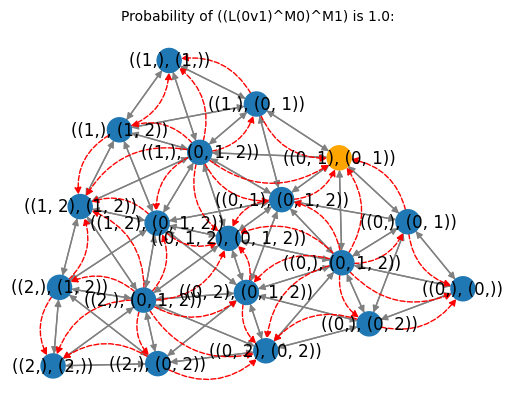

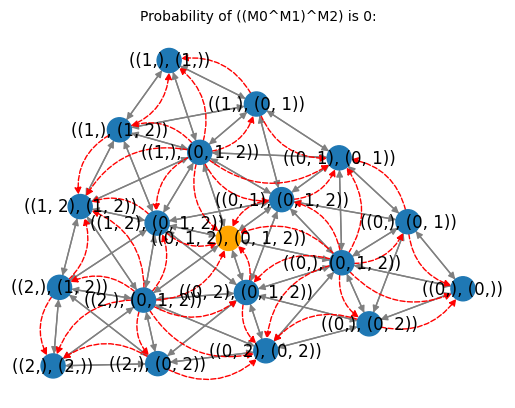

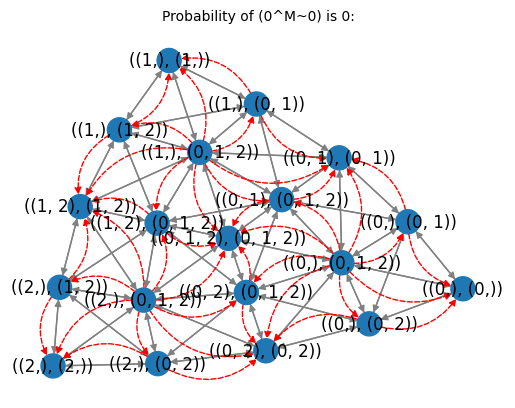

In [45]:
three_worlds_prob_after_learning = {0:1/2,1:1/2,2:0}

for form in ['0','((0v1)^(0v2))','L0','M0','(0v1)','((0v1)^M0)','(((0v1)^M0)^M1)','L(0v1)','((L(0v1)^M0)^M1)','((M0^M1)^M2)','(0^M~0)']:
    ext = extension(form,frame_from_three_worlds[1],frame_from_three_worlds[2],frame_from_three_worlds[3])
    prob = probability_in_compatibility_frame_from_worlds(ext,three_worlds_prob_after_learning)
    draw_frame(frame_from_three_worlds[0],frame_from_three_worlds[1],frame_from_three_worlds[2],ext,title=f"Probability of {form} is {prob}:")

In [46]:
frame_from_four_worlds = compatibility_frame_from_worlds(range(4))
len(frame_from_four_worlds[0])

65

# 9. Lifting a selection function from the world model to the epistemic compatibility model

In this section, we lift a Stalnaker-style selection function from a world model to the epistemic compatibility model constructed in the previous section.

As an example, we use a Stalnaer-style model whose points are *sequences* of worlds, since this facilitates defining the selection function. We use the following to generate all the permutations of an initial set of worlds.

In [47]:
def perms(urn, num_to_draw = None):
    """
    Returns all permutations of subsets of urn of size num_to_draw (default is len(urn))
    """
    if num_to_draw == None:
        num_to_draw = len(urn)

    return _perms(urn,num_to_draw,[])

def _perms(urn, num_to_draw, sequence):

    if num_to_draw == 1:
        for w in urn:
            yield tuple(sequence + [w])

    if num_to_draw > 1:
        for w in urn:
            yield from _perms([v for v in urn if not v==w], num_to_draw-1, sequence + [w])

We will consider the set of six sequences of three worlds, together with the uniform probability distribution over the six sequences.

In [48]:
six_sequences = list(perms(range(3)))

six_sequences_val = dict()
for n in range(3):
    six_sequences_val[str(n)] = [seq for seq in six_sequences if seq[0] == n]

six_sequences_prob = dict()
for seq in six_sequences:
    six_sequences_prob[seq] = 1/6

In [49]:
print(six_sequences_val)

{'0': [(0, 1, 2), (0, 2, 1)], '1': [(1, 0, 2), (1, 2, 0)], '2': [(2, 0, 1), (2, 1, 0)]}


In [50]:
print(six_sequences_prob)

{(0, 1, 2): 0.16666666666666666, (0, 2, 1): 0.16666666666666666, (1, 0, 2): 0.16666666666666666, (1, 2, 0): 0.16666666666666666, (2, 0, 1): 0.16666666666666666, (2, 1, 0): 0.16666666666666666}


In [51]:
def world_prop_to_sequence_prop(world_prop,sequences):

    return frozenset(sorted([seq for seq in sequences if seq[0] in world_prop]))

In [52]:
world_prop_to_sequence_prop([0,1],six_sequences)

frozenset({(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0)})

For our set of sequences, let a *descriptive selection function* be a function that takes in a sequence $s$ and a set  $\mathbf{A}$ of sequences that is the image of a set $A$ of worlds as above and returns a new sequence $s'$. We call this a "descriptive" selection function because it it only defined for sets of sequences that "project down" to a set of worlds. In fact, for efficiency of computation we will just give the selection function $s$ and $A$ (the set of *worlds*). We then construct $s'$ by putting all $A$-worlds before all not-$A$-worlds but keeping the ordering of the $A$-worlds (resp. not-$A$-worlds) the same (so-called "radical upgrade with $A$" in belief revision).

In [53]:
worlds = range(3)
selection = dict()
for seq in six_sequences:
    for prop in powerset(worlds):
        selection[(seq,frozenset(prop))] = tuple([w for w in seq if w in prop] + [w for w in seq if not w in prop])

In [54]:
print(selection)

{((0, 1, 2), frozenset()): (0, 1, 2), ((0, 1, 2), frozenset({0})): (0, 1, 2), ((0, 1, 2), frozenset({1})): (1, 0, 2), ((0, 1, 2), frozenset({2})): (2, 0, 1), ((0, 1, 2), frozenset({0, 1})): (0, 1, 2), ((0, 1, 2), frozenset({0, 2})): (0, 2, 1), ((0, 1, 2), frozenset({1, 2})): (1, 2, 0), ((0, 1, 2), frozenset({0, 1, 2})): (0, 1, 2), ((0, 2, 1), frozenset()): (0, 2, 1), ((0, 2, 1), frozenset({0})): (0, 2, 1), ((0, 2, 1), frozenset({1})): (1, 0, 2), ((0, 2, 1), frozenset({2})): (2, 0, 1), ((0, 2, 1), frozenset({0, 1})): (0, 1, 2), ((0, 2, 1), frozenset({0, 2})): (0, 2, 1), ((0, 2, 1), frozenset({1, 2})): (2, 1, 0), ((0, 2, 1), frozenset({0, 1, 2})): (0, 2, 1), ((1, 0, 2), frozenset()): (1, 0, 2), ((1, 0, 2), frozenset({0})): (0, 1, 2), ((1, 0, 2), frozenset({1})): (1, 0, 2), ((1, 0, 2), frozenset({2})): (2, 1, 0), ((1, 0, 2), frozenset({0, 1})): (1, 0, 2), ((1, 0, 2), frozenset({0, 2})): (0, 2, 1), ((1, 0, 2), frozenset({1, 2})): (1, 2, 0), ((1, 0, 2), frozenset({0, 1, 2})): (1, 0, 2), ((1

In [55]:
p = frozenset([2])

selection[((0, 1, 2),p)]

(2, 0, 1)

Now we build the epistemic compatibility frame from the six sequences.

In [56]:
frame_from_six_sequences = compatibility_frame_from_worlds(six_sequences,six_sequences_val)

In [117]:
count = 0
for poss in frame_from_six_sequences[0]:
    print(poss)
    count += 1
    if count == 10:
        break

(((0, 1, 2),), ((0, 1, 2),))
(((0, 1, 2),), ((0, 1, 2), (0, 2, 1)))
(((0, 1, 2),), ((0, 1, 2), (1, 0, 2)))
(((0, 1, 2),), ((0, 1, 2), (1, 2, 0)))
(((0, 1, 2),), ((0, 1, 2), (2, 0, 1)))
(((0, 1, 2),), ((0, 1, 2), (2, 1, 0)))
(((0, 1, 2),), ((0, 1, 2), (0, 2, 1), (1, 0, 2)))
(((0, 1, 2),), ((0, 1, 2), (0, 2, 1), (1, 2, 0)))
(((0, 1, 2),), ((0, 1, 2), (0, 2, 1), (2, 0, 1)))
(((0, 1, 2),), ((0, 1, 2), (0, 2, 1), (2, 1, 0)))


In [58]:
set_of_poss = {(((0, 1, 2),), ((0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)))}

probability_in_compatibility_frame_from_worlds(set_of_poss,six_sequences_prob)

0.16666666666666666

In [82]:
def lifted_selection(worlds, seq_selection, possibilities):
    """Given a set W of worlds, a descriptive selection function for the sequence model S constructed from W,
    and the set of possibilities for the epistemic compatibility model constructed from S,
    return the lifted descriptive selection function for the epistemic compatibility model"""

    new_selection = dict()

    for poss in possibilities:
        for prop in powerset(worlds):
            if len(prop) >0:
                frozen_prop = frozenset(prop)
                new_selection[(poss,frozen_prop)] = (tuple(sorted({seq_selection[(seq,frozen_prop)] for seq in poss[0]})),tuple(sorted({seq_selection[seq,frozen_prop] for seq in poss[1]})))
    
    return new_selection

In [83]:
new_selection = lifted_selection(range(3), selection, frame_from_six_sequences[0])

In [139]:
def extension2(formula, compat_rel, access_rel, selection, valuation):
    """
    Given a formula, compatibility and accessibility relations, and a valuation,
    returns the extension of the formula as a set of possibilities
    """
    dom = access_rel.keys()
    
    main_connec = main_connective(formula)

    if main_connec[0] == 'prop':

        return set([x for x in dom if x in valuation[main_connec[1]]])

    if main_connec[0] == '~':
        inner_ext = set(extension2(main_connec[1],compat_rel,access_rel,selection,valuation))
        return neg(inner_ext, compat_rel)

    if main_connec[0] == 'L':
        inner_ext = set(extension2(main_connec[1],compat_rel,access_rel,selection,valuation))
        return box(inner_ext,access_rel)
    
    if main_connec[0] == 'M':
        inner_ext = set(extension2(main_connec[1],compat_rel,access_rel,selection,valuation))
        return diamond(inner_ext,compat_rel,access_rel)

    if main_connec[0] == '^':
        left_ext = extension2(main_connec[1],compat_rel,access_rel,selection,valuation)
        right_ext = extension2(main_connec[2],compat_rel,access_rel,selection,valuation)
        return wedge(left_ext,right_ext)

    if main_connec[0] == 'v':
        left_ext = extension2(main_connec[1],compat_rel,access_rel,selection,valuation)
        right_ext = extension2(main_connec[2],compat_rel,access_rel,selection,valuation)
        return vee(left_ext,right_ext,compat_rel)
    
    if main_connec[0] == '>':
        ant_ext = extension2(main_connec[1],compat_rel,access_rel,selection,valuation)

        if len(ant_ext) == 0:
            return dom
        
        ant_worlds = list()
        for poss in ant_ext:
            for seq in poss[0]:
                    ant_worlds.append(seq[0])
                    
        cons_ext = extension2(main_connec[2],compat_rel,access_rel,selection,valuation)
        return set([poss for poss in dom if selection[(poss,frozenset(ant_worlds))] in cons_ext])

In [150]:
for form in ['0','L0','M~0','((0v1)>0)','(L(0v1)>0)','(M(0v1)>0)','((0v1)>L0)','(0>M~0)', '(~0>(1v2))', '(M~0>(1v2))','(M~0>~0)','(M~0>0)','((0^~0)>1)','((0^M~0)>1)','(((0v1)>0)>0)','(((0v(1v2))>0)>0)','(((0v1)>0)^((0v1)>1))','(((0v1)>0)^((0v2)>0))','(((0v1)>0)^((0v2)>2))']:
    ext = extension2(form,frame_from_six_sequences[1],frame_from_six_sequences[2],new_selection,frame_from_six_sequences[3])
    pr = round(probability_in_compatibility_frame_from_worlds(ext,six_sequences_prob),2)
    print(f"Probability of {form}:", pr)

Probability of 0: 0.33
Probability of L0: 0
Probability of M~0: 1.0
Probability of ((0v1)>0): 0.5
Probability of (L(0v1)>0): 0.5
Probability of (M(0v1)>0): 0.33
Probability of ((0v1)>L0): 0
Probability of (0>M~0): 0
Probability of (~0>(1v2)): 1.0
Probability of (M~0>(1v2)): 0.67
Probability of (M~0>~0): 0.67
Probability of (M~0>0): 0.33
Probability of ((0^~0)>1): 1.0
Probability of ((0^M~0)>1): 1.0
Probability of (((0v1)>0)>0): 0.5
Probability of (((0v(1v2))>0)>0): 1.0
Probability of (((0v1)>0)^((0v1)>1)): 0
Probability of (((0v1)>0)^((0v2)>0)): 0.33
Probability of (((0v1)>0)^((0v2)>2)): 0.17


# 10. Epistemic Levels  

In [66]:
def one_step_ortho_closure(prop,reldict):
    "given a list props of propositions, add their negations (relative to rel) and pairwise intersections"
    close = copy.deepcopy(prop)

    for A in prop:
        negA = neg(A,reldict)
        if negA not in close:
            close.append(neg(A,reldict))

    for A in prop:
        for B in prop:
            AandB = wedge(A,B)
            if AandB not in close:
                close.append(wedge(A,B))

    return close

In [67]:
one_step = one_step_ortho_closure([{0,1}],scale_rel_dict)

print(one_step)

two_step = one_step_ortho_closure(one_step,scale_rel_dict)

print(two_step)

three_step = one_step_ortho_closure(two_step,scale_rel_dict)

print(three_step)

[{0, 1}, {3, 4}]
[{0, 1}, {3, 4}, set()]
[{0, 1}, {3, 4}, set(), {0, 1, 2, 3, 4}]


In [68]:
def ortho_closure(props, rel):
    "given a list props of propositions, take the closure under negation (relative to rel) and binary intersection"
    close = copy.deepcopy(props)

    while not close == one_step_ortho_closure(close,rel):
        close = one_step_ortho_closure(close,rel)

    return close

In [69]:
scale_B0 = ortho_closure([{0,1}],scale_rel_dict)

In [70]:
def check_Boolean(props,reldict):
    "given a list props of propositions, check whether the condition guaranteeing Booleaness in Proposition 4.40 holds"
    for A in props:
        for B in props:
            for x in A:
                for y in B:
                    if y in reldict[x]:
                        if len([z for z in A if z in B]) == 0:
                            print("A is", A)
                            print("B is ",B)
                            print("x is", x)
                            print("y is ",y)
                            return False
    
    return True

In [71]:
L = fixpoints(scale_rel_dict)

check_Boolean(L, scale_rel_dict)

A is {3, 4}
B is  {2}
x is 3
y is  2


False

In [72]:
check_Boolean(scale_B0, scale_rel_dict)

True

In [73]:
def boxed_elements(props,access):
    "given a list props of propositions, return a list of all the boxed propositions"
    boxed = []

    for A in props:
        boxed.append(box(A,access))

    return boxed

In [74]:
ortho_closure(boxed_elements(scale_B0,access_on_scale_dict),scale_rel_dict)

[{0}, {4}, set(), {0, 1, 2, 3, 4}, {2, 3, 4}, {0, 1, 2}, {2}, {0, 4}]

In [75]:
def epistemic_level(rel, access, B, n):
    "given a compatibility and accessibility relations and distinguished propositions in B, return the set B_n from Definition 3.31"
    if n == 0:
        return ortho_closure(B,rel)
    
    if n > 0: 
       return ortho_closure(boxed_elements(epistemic_level(rel,access,B,n-1),access),rel) 

In [76]:
epistemic_level(scale_rel_dict,access_on_scale_dict, [{0,1}],0)

[{0, 1}, {3, 4}, set(), {0, 1, 2, 3, 4}]

In [77]:
epistemic_level(scale_rel_dict,access_on_scale_dict, [{0,1}],1)

[{0}, {4}, set(), {0, 1, 2, 3, 4}, {2, 3, 4}, {0, 1, 2}, {2}, {0, 4}]

In [78]:
epistemic_level(scale_rel_dict,access_on_scale_dict, [{0,1}],2)

[{0}, {4}, set(), {0, 1, 2, 3, 4}, {2, 3, 4}, {0, 1, 2}, {2}, {0, 4}]

In [79]:
check_Boolean(epistemic_level(scale_rel_dict,access_on_scale_dict, [{0,1}],1), scale_rel)

A is {4}
B is  {0, 1, 2}
x is 4
y is  2


False

In [80]:
def stratified(rel, access, B):
    "check whether the given grounded modal compatibility frame is stratified as in Definition 4.39"
    n = 0

    if not check_Boolean(epistemic_level(rel,access, B, 0), rel):
        return False

    while not epistemic_level(rel,access,B,n+1) == epistemic_level(rel,access,B,n):
        
        if not check_Boolean(epistemic_level(rel,access, B, n+1), rel):
            return False 

        n += 1

    return True

In [81]:
stratified(scale_rel_dict,access_on_scale_dict,[{0,1}])

True